<a href="https://colab.research.google.com/github/chinardankhara/nlphuggingface/blob/main/textclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get Dataset

In [2]:
from datasets import list_datasets, load_dataset

In [4]:
datasets = list_datasets()
print(f"Number of datasets: {len(datasets)}")
print(f"First 10: {datasets[:10]}")

Number of datasets: 36488
First 10: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [6]:
emotions = load_dataset("emotion")
emotions

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Wrangling and analysis

In [16]:
train_ds = emotions['train']
print(train_ds.column_names)
print(train_ds.features)

['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [20]:
emotions.set_format('pandas')
df = emotions["train"][:]
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [22]:
def labelname(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(labelname)

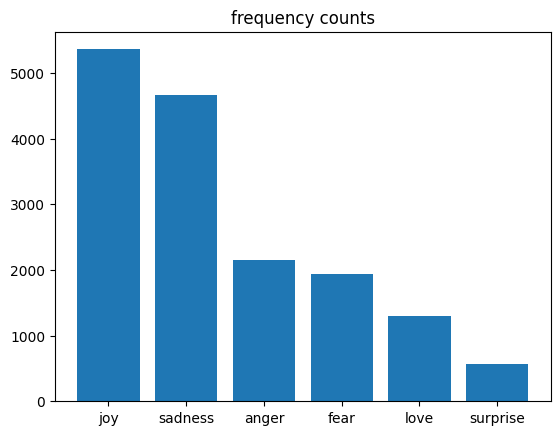

In [24]:
import matplotlib.pyplot as plt

value_counts = df['label_name'].value_counts()

# Create a bar plot
plt.bar(value_counts.index, value_counts.values)
plt.title("frequency counts")
plt.show()

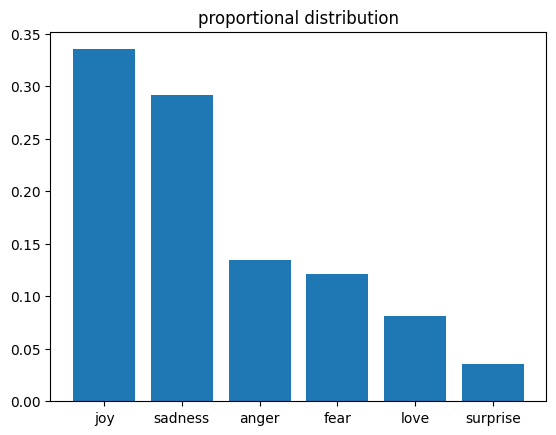

In [27]:
plt.bar(value_counts.index, (value_counts.values/len(df["label_name"])))
plt.title("proportional distribution")
plt.show()

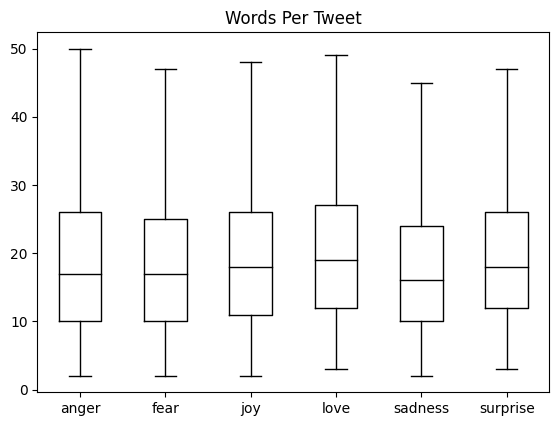

In [29]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

#well under the max context length for distilBERT

In [30]:
emotions.reset_format()

### Character Tokenization

In [42]:
text = emotions["train"][0]["text"]
tokenized_text = list(text)

input_mapping = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}

input_ids = [input_mapping[token] for token in tokenized_text]
input_ids

[6, 0, 2, 6, 2, 9, 10, 0, 4, 3, 3, 7, 0, 5, 11, 8, 6, 7, 6, 1, 10, 3, 2]

In [46]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot = F.one_hot(input_ids, num_classes = len(input_mapping))

### Better Tokenization

In [53]:
from transformers import AutoTokenizer

tokenizer_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)

In [54]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [62]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(' '.join(i for i in tokens),':::', tokenizer.convert_tokens_to_string(tokens))

[CLS] i didn ##t feel humiliated [SEP] ::: [CLS] i didnt feel humiliated [SEP]


In [65]:
print(tokenizer.vocab_size, tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522 512
['input_ids', 'attention_mask']


In [66]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions = emotions.map(tokenize, batched = True, batch_size = None)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]